In [8]:
import os, random
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
import pandas as pd

In [51]:
model = gum.BayesNet()

nodeList = ["RR",
            "HR",
            "Temp",
            "GSR",
            "Physiological Workload"
           ]

#maxRange = 2
#bins={n:[i for i in range(maxRange)] for n in nodeList}

classLabels = ["Rest", "Load"]

for node in nodeList:
    model.add(gum.LabelizedVariable(node,node,classLabels))

model.addArc('RR','Physiological Workload')
model.addArc('HR','Physiological Workload')
model.addArc('Temp','Physiological Workload')
model.addArc('GSR','Physiological Workload')


model

(pyAgrum.BayesNet<double>@000001765920DEF0) BN{nodes: 5, arcs: 4, domainSize: 32, dim: 20, mem: 320o}

In [93]:
model.cpt("RR")[:]=1
model.cpt("HR")[:]=1
model.cpt("GSR")[:]=1
model.cpt("Temp")[:]=1
model.cpt("Physiological Workload")[:]=1

frames = 30
skip = 1
cv=0
#model = "LSTM"
modelType = "TCN"
data=[[] for i in range(4)]
for index, p in enumerate(nodeList[:-1]):

    #p = "Temp"
    predict_path = f".\\save\\{modelType}\\{p}_frame{frames}_skip{skip}_cv{cv}_predict_test.npy"
    prediction = np.load(predict_path)

    #truth_path = f".\\save\\{modelType}\\{p}_frame{frames}_skip{skip}_truth_test.npy"
    #truth = np.load(truth_path)

    rest = prediction==1

    model.cpt(p)[:] = [sum(rest), len(rest)-sum(rest)]

    data[index].append(prediction)

    
data = np.array(data)
data=np.swapaxes(data,1,-1)
data = data[:,:,0]
import pandas as pd

df = pd.DataFrame(np.transpose(data), columns=nodeList[:-1])

for hr in range(2):
    for rr in range(2):
        for gsr in range(2):
            for temp in range(2):   
                #temp_df = df[(df["HR"]==hr) & (df["RR"]==rr) & (df["GSR"]==gsr) & (df["Temp"]==temp)]
                #model.cpt("Physiological Workload")[{'RR': rr, 'HR': hr, 'Temp': temp, 'GSR': gsr}]=[1,len(temp_df)]  
                val = [rr,hr,temp,gsr]
                model.cpt("Physiological Workload")[{'RR': rr, 'HR': hr, 'Temp': temp, 'GSR': gsr}]=[val.count(0), val.count(1)] 
                

#model.cpt("Physiological Workload").fillWithFunction("(HR+RR+GSR+Temp)")

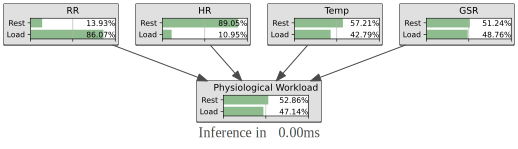

In [94]:
gnb.showInference(model, evs={},size="10")

In [147]:
#multi network
model = gum.BayesNet()

modelList = ["TCN", "LSTM", "BiLSTM","TCN+LSTM"]

nodeList = ["RR",
            "HR",
            "Temp",
            "GSR",
            "Physiological Workload"
           ]

classLabels = ["Rest", "Load"]

model.add(gum.LabelizedVariable('Physiological Workload','Physiological Workload',classLabels))

for mod in modelList:
    for node in nodeList:
        model.add(gum.LabelizedVariable(mod+node,mod+node,classLabels))

    model.addArc(mod+'RR',mod+'Physiological Workload')
    model.addArc(mod+'HR',mod+'Physiological Workload')
    model.addArc(mod+'Temp',mod+'Physiological Workload')
    model.addArc(mod+'GSR',mod+'Physiological Workload')
    
    model.addArc(mod+'Physiological Workload','Physiological Workload')

model

(pyAgrum.BayesNet<double>@0000017659210D70) BN{nodes: 21, arcs: 20, domainSize: 10^6.32163, dim: 96, mem: 1Ko 512o}

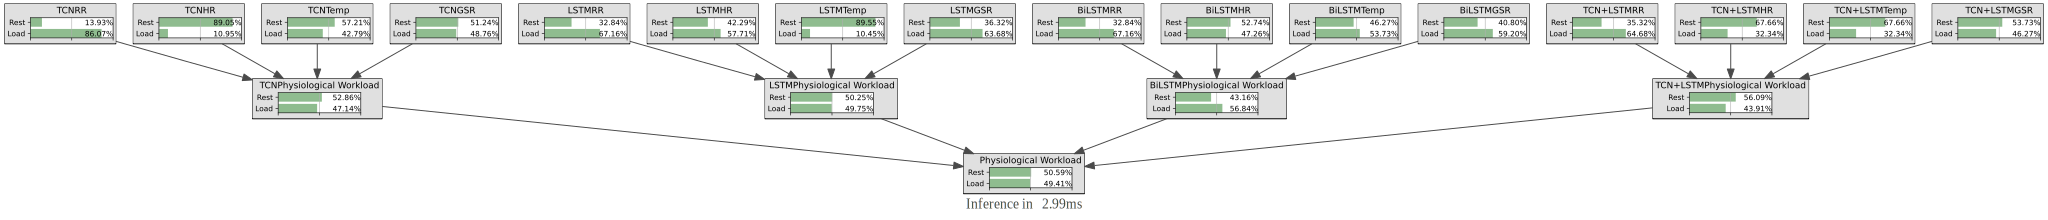

In [152]:
for mod in modelList:
    model.cpt(mod+"RR")[:]=1
    model.cpt(mod+"HR")[:]=1
    model.cpt(mod+"GSR")[:]=1
    model.cpt(mod+"Temp")[:]=1
    model.cpt(mod+"Physiological Workload")[:]=1
    
model.cpt('Physiological Workload')[:]=1

frames = 30
skip = 1
cv=0

for modelType in modelList:

    data=[[] for i in range(4)]
    for index, p in enumerate(nodeList[:-1]):
        predict_path = f".\\save\\{modelType}\\{p}_frame{frames}_skip{skip}_cv{cv}_predict_test.npy"
        prediction = np.load(predict_path)

        rest = prediction==1

        model.cpt(modelType+p)[:] = [sum(rest), len(rest)-sum(rest)]

        data[index].append(prediction)


    data = np.array(data)
    data=np.swapaxes(data,1,-1)
    data = data[:,:,0]
    import pandas as pd

    df = pd.DataFrame(np.transpose(data), columns=nodeList[:-1])

    for hr in range(2):
        for rr in range(2):
            for gsr in range(2):
                for temp in range(2):   
                    val = [rr,hr,temp,gsr]
                    model.cpt(modelType+"Physiological Workload")[{modelType+'RR': rr, modelType+'HR': hr, modelType+'Temp': temp, modelType+'GSR': gsr}]=[val.count(0), val.count(1)] 

for tcn in range(2):
    for lstm in range(2):
        for bilstm in range(2):
            for tcnlstm in range(2):   
                val = [tcn,lstm,bilstm,tcnlstm]
                
                model.cpt("Physiological Workload")[{modelList[0]+"Physiological Workload": tcn, 
                                                     modelList[1]+"Physiological Workload": lstm, 
                                                     modelList[2]+"Physiological Workload": bilstm, 
                                                     modelList[3]+"Physiological Workload": tcnlstm}]=[val.count(0), val.count(1)] 

gnb.showInference(model, evs={}, size='45')    


In [104]:
bn = gum.fastBN('Age{18-24|25-34|35-64}->Sex{male|female};' +
                                
                'diligence{1|2|3|4|5}->conscientiouness{R|S};'+
                'prudence{1|2|3|4|5}->conscientiouness;'+
                'flexibility{1|2|3|4|5}->agreeableness{R|S};'+
                'gentleness{1|2|3|4|5}->agreeableness;'+
                'patience{1|2|3|4|5}->agreeableness;'+
                'fairness{1|2|3|4|5}->honesty{R|S};'+
                'greed_avoidance{1|2|3|4|5}->honesty;'+
                'modesty{1|2|3|4|5}->honesty;'+
                'sincerity{1|2|3|4|5}->honesty;'+
                'liveliness{1|2|3|4|5}->extraversion{R|S};'+
                'sociability{1|2|3|4|5}->extraversion;'+
                'social_boldness{1|2|3|4|5}->extraversion;'+
                'openess{1|2|3|4|5}->experience{R|S};'+
                'dependence{1|2|3|4|5}->emotionality{R|S};'+
                
                'conscientiouness->Psychological_traits{R|S};'+
                'agreeableness->Psychological_traits;'+
                'honesty->Psychological_traits;'+
                'extraversion->Psychological_traits;'+
                'emotionality->Psychological_traits;'+
                'experience->Psychological_traits;'+
                
                'Sex->Personal_trait{R|N|S};'+
                'Psychological_traits->Personal_trait;'+
              
                'RR{Rest|Load}->Physiological_workload_markers{Rest|Load};' +
                'HR{Rest|Load}->Physiological_workload_markers;' +
                'Temp{Rest|Load}->Physiological_workload_markers;' +
                'GSR{Rest|Load}->Physiological_workload_markers;'+
                
                'Personal_trait->Workload{Rest|Load}<-Physiological_workload_markers;'
                )

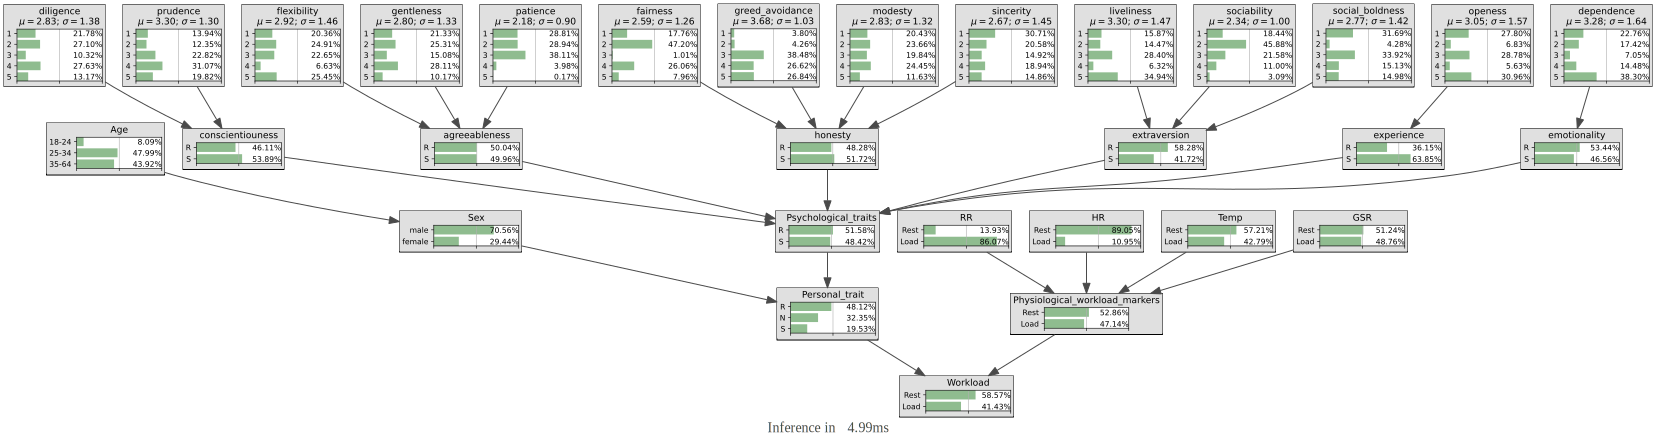

In [108]:
#populate the ML portion

bn.cpt("RR")[:]=1
bn.cpt("HR")[:]=1
bn.cpt("GSR")[:]=1
bn.cpt("Temp")[:]=1
bn.cpt("Physiological_workload_markers")[:]=1

frames = 30
skip = 1
cv=0
modelType = "TCN"

data=[[] for i in range(4)]
for index, p in enumerate(nodeList[:-1]):
    predict_path = f".\\save\\{modelType}\\{p}_frame{frames}_skip{skip}_cv{cv}_predict_test.npy"
    prediction = np.load(predict_path)

    rest = prediction==1

    bn.cpt(p)[:] = [sum(rest), len(rest)-sum(rest)]

    data[index].append(prediction)

    
data = np.array(data)
data=np.swapaxes(data,1,-1)
data = data[:,:,0]
import pandas as pd

df = pd.DataFrame(np.transpose(data), columns=nodeList[:-1])

for hr in range(2):
    for rr in range(2):
        for gsr in range(2):
            for temp in range(2):   
                val = [rr,hr,temp,gsr]
                bn.cpt("Physiological_workload_markers")[{'RR': rr, 'HR': hr, 'Temp': temp, 'GSR': gsr}]=[val.count(0), val.count(1)] 
gnb.showInference(bn, evs={}, size='45')            

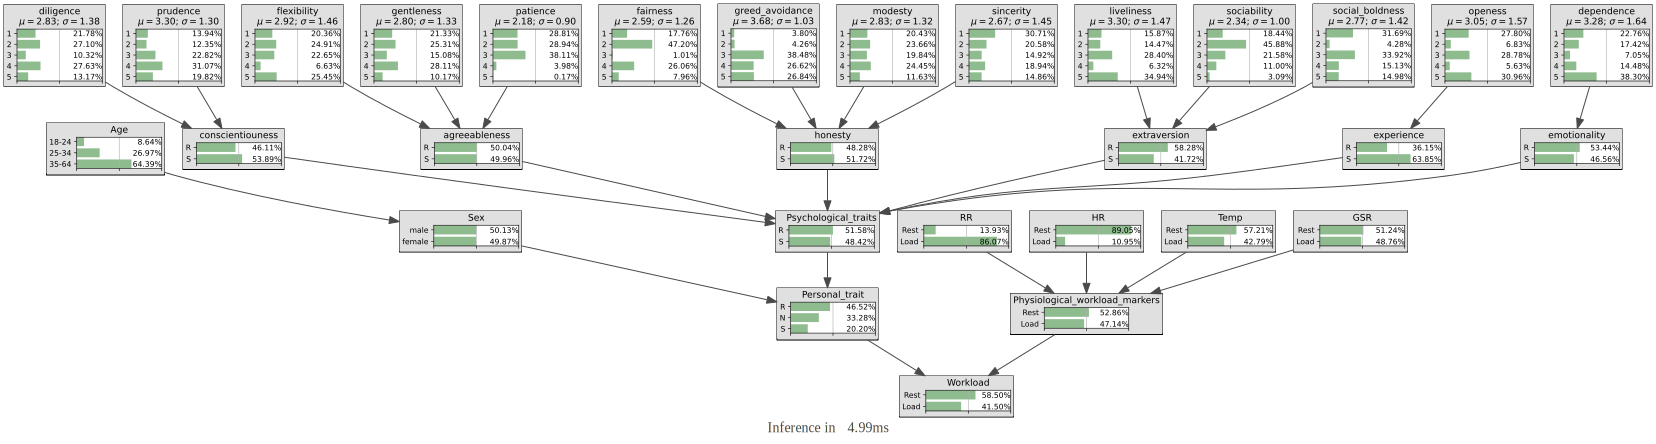

In [115]:
#Age + sex
demogr = pd.read_csv('BN_data//age_sex.csv')
bn.cpt('Age')[:] = (demogr['Total']/np.sum(demogr['Total'])).sort_index().values.tolist()

m = np.sum(demogr['Males'])
f = np.sum(demogr['Females'])
total = m+f

for i in range(0, 3): #age
    m = (demogr['Males'][i])
    f = (demogr['Females'][i])
    
    bn.cpt('Sex')[{'Age': i}] = [m, f]
gnb.showInference(bn, evs={}, size='45')    

In [120]:
person = pd.read_csv('BN_data//personality_for_bn1.csv')

trait = ['diligence',
'prudence',
'flexibility',
'gentleness',
'patience',
'fairness',
'greed_avoidance',
'modesty',
'sincerity',
'liveliness',
'sociability',
'social_boldness',
'openess',
'dependence']
all_values = range(1, 6)

# Iterate through the list
for value in trait:
    #print(value)
    count = person[value].value_counts().sort_index()#.values.tolist()
    count = count.reindex(all_values, fill_value=0).values.tolist()
    bn.cpt(value)[:] = count/ np.sum(count)

#experience
for i in range(0, 5):
    if person['openess'][i] >=3 :
        prob = [0.9, 0.1]
    else:
        prob = [0.5, 0.5]
    bn.cpt('experience')[{'openess': i}] = prob
    

for i in range(0, 5):
    #emotionality
    bn.cpt('emotionality')[{'dependence': i}] = [0.5, 0.5]

for i in range(0, 5):
    for j in range(0, 5):
        for k in range(0, 5):
            #extraversion
            stress = person['social_boldness'][i] + person['sociability'][j]
            rest = person['liveliness'][k]
            if stress >= rest:
                prob = [0.33, 0.67]
            else:
                prob = [0.67, 0.33]
            bn.cpt('extraversion')[{'social_boldness': i, 'sociability': j, 'liveliness': k}] = prob    

for i in range(0, 5):
    for j in range(0, 5):
        for k in range(0, 5):
            for l in range(0, 5):
                #honesty
                stress = person['fairness'][l] + person['greed_avoidance'][j] + person['modesty'][i]
                rest = person['sincerity'][k] + person['fairness'][l]
                if stress >= rest:
                    prob = [0.4, 0.6]
                else:
                    prob = [0.6, 0.4]
                bn.cpt('honesty')[{'modesty': i, 'greed_avoidance': j, 'sincerity': k, 'fairness': l}] = prob 

for i in range(0, 5):
    for j in range(0, 5):
        for k in range(0, 5):
            #agreeableness
            stress = person['gentleness'][j]
            rest = person['flexibility'][i] + person['patience'][k]
            if stress >= rest:
                prob = [0.33, 0.67]
            else:
                prob = [0.67, 0.33]
            bn.cpt('agreeableness')[{'flexibility': i, 'gentleness': j, 'patience': k}] = prob  
            
for i in range(0, 5):
    for j in range(0, 5):
        #conscientiouness
        stress = person['diligence'][i] + person['prudence'][j]
        if stress >= 5:
            prob = [0.1, 0.9]
        else:
            prob = [0.5, 0.5]
        bn.cpt('conscientiouness')[{'diligence': i, 'prudence': j}] = prob 
        
for i in range(0, 2): #experience
    for j in range(0, 2): #emotionality
        for k in range(0, 2): #extraversion
            for l in range(0, 2): #honesty
                for m in range(0, 2): #agreeableness
                    for n in range(0, 2): #conscientiouness
                        val = [i,j,k,l,m,n]
                        count_0 = val.count(0)
                        count_1 = val.count(1)
                        total = count_0+count_1
                        bn_val = {'experience': i, 'emotionality': j, 'extraversion': k, 'honesty': l, 'agreeableness': m, 'conscientiouness': n} 
                        bn.cpt('Psychological_traits')[bn_val] = [count_0/total, count_1/total]
                        

In [122]:
import itertools

col_person = ['sex_male', 'state', 'tlx_bool']
subset_df_person = person[col_person]
df_person = subset_df_person.groupby(col_person).size().reset_index(name="count")
df_person

# Generate all possible combinations of values and Convert the combinations into a DataFrame
combinations = list(itertools.product([0, 1], [0, 1, 2], [0, 1]))
combinations_df = pd.DataFrame(combinations, columns=df_person.columns[:-1])

merged_df = pd.merge(df_person, combinations_df, on=df_person.columns[:-1].tolist(), how='right')

# Fill missing values with 0 for the count column
merged_df['count'] = merged_df['count'].fillna(0)
merged_df = merged_df[df_person.columns]

#print(merged_df)
merged_df = merged_df.sort_values('tlx_bool').reset_index(drop=True)
#print(merged_df)
for index, row in merged_df.iloc[::3].iterrows():
    value_bn = {'Psychological_traits': int(merged_df['tlx_bool'][index]), 'Sex': int(merged_df['sex_male'][index])}
    prob = [merged_df['count'][index], merged_df['count'][index+1], merged_df['count'][index+2]]
    prob = prob/np.sum(prob)
    #print(value_bn, prob)
    bn.cpt('Personal_trait')[value_bn] = prob
    

In [133]:
for i in range(0, 3): #Personal_trait
    for j in range(0, 2): #Physiological_workload_markers
        #print(gum.getPosterior(bn, {}, 'Personal_trait')[i],gum.getPosterior(bn, {}, 'Physiological_workload_markers')[j])
        person = gum.getPosterior(bn, target='Personal_trait')[i]
        wload = gum.getPosterior(bn, target='Physiological_workload_markers')[j]
        t = person+wload - wload*person
        f = 1 - t
        prob = [t, f]
        if j == 1:
            prob = [f, t]
        value_bn = {'Personal_trait': i, 'Physiological_workload_markers': j}
        print (value_bn, prob)
        bn.cpt('Workload')[value_bn] = prob

{'Personal_trait': 0, 'Physiological_workload_markers': 0} [0.5497912609128641, 0.4502087390871359]
{'Personal_trait': 0, 'Physiological_workload_markers': 1} [0.50485148842225, 0.49514851157775]
{'Personal_trait': 1, 'Physiological_workload_markers': 0} [0.8901266982695171, 0.10987330173048293]
{'Personal_trait': 1, 'Physiological_workload_markers': 1} [0.12320884758695316, 0.8767911524130468]
{'Personal_trait': 2, 'Physiological_workload_markers': 0} [0.6172959711658774, 0.3827040288341226]
{'Personal_trait': 2, 'Physiological_workload_markers': 1} [0.42915359433905564, 0.5708464056609444]


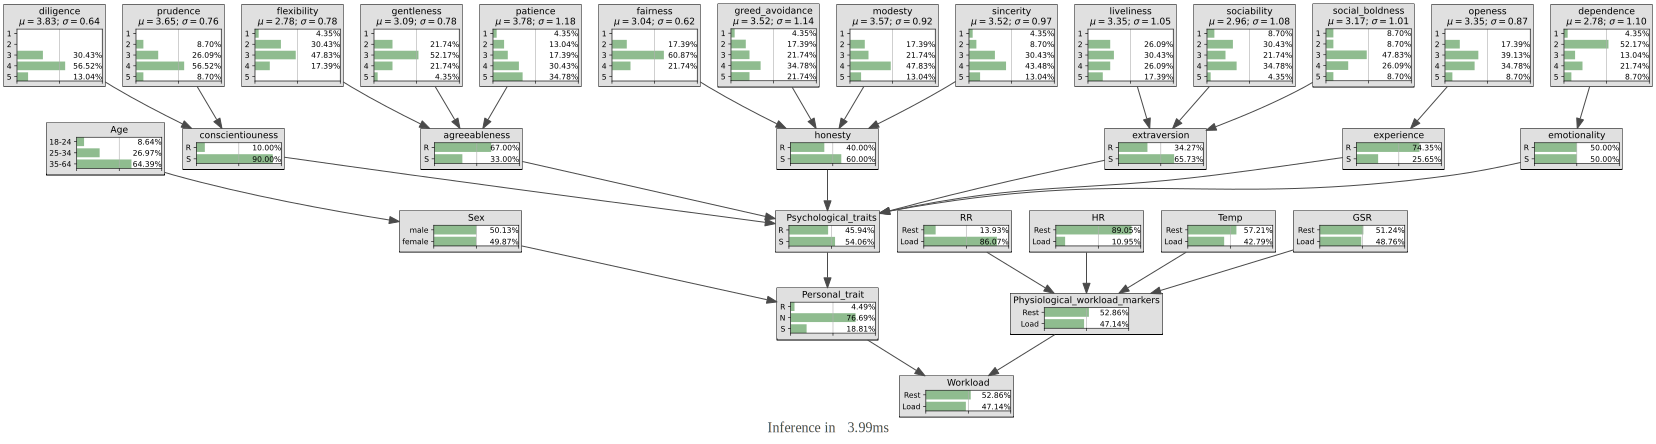

In [134]:
gnb.showInference(bn, evs={}, size='45')   